From Megan's notes at: https://uoregonctn.atlassian.net/wiki/spaces/DE/pages/1744076802/RTFS+and+Stop+Signal+Distress

### The plan

Neural activity of the go trial immediately following a failed stop compared to (all/previous trial) go trials following a correct stop. For each subject, run the following to get an individual difference measure.  Here is a univariate version, that is less sensitive. 

Step 1: Find a mask from dACC

Step 2: What if you do a machine learning classifier or similarity/dissimilarity matrix within the voxels from step 1 (< more direct measure) 

Step 3: Obtain the correlation between the post-failure versus post-correct, then regress this on FFQ.

Step 4: Repeat for emotional regulation 

Work with Rob or Dasha to look at Individual difference measure #2, a post no error minus pre no error comparison as a control.  (OR post error versus the next post correct)  

### Using existing betas

1. load the betas
2. do behavioral analysis to identify post-failure and post-current events
3. Take the correlations between each.


### Using a beta-average approach

1. Do behavioral analyses to identify post-failure and post-current events
2. From this, create a beta series
3. Do extraction.
4. Run correlation.

Although we have to work a bit harder to get it, I'm going to use the second method because I think it'll be more reliable.

We modify multiconds.py to do the job.

This file takes content from regress_on_nogo_go_pattern.

#### Setup

In [1]:
import sys
import os
import pandas as pd
from os import path

import pickle
from IPython.core.display import display, HTML, Markdown

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'posterror_conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
#get the masks we want




python initialized for apply_loocv_and_save
4


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Learn with ACC mask

#### masking

In [2]:
acc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.nii.gz').threshold(binarize=True,upper=25).to_nifti()

background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [3]:
acc_mask

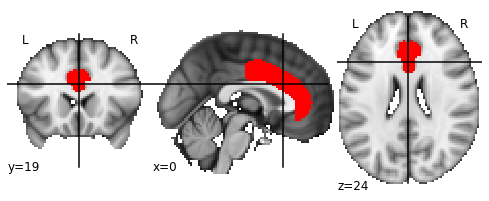

In [4]:
from nilearn import plotting
plotting.plot_img(acc_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)

#### generate neural signatures

In [5]:
def condition_resp_trans_func(X):
    return(X.condition_label)

In [6]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_accmask.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [7]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=acc_mask
    )

In [8]:
print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_accmask.pkl


In [9]:
np.mean(results[0])

0.6049382716049383

In [10]:
results[3]

{'CorrectGoFollowingCorrectStop': <nibabel.nifti1.Nifti1Image at 0x2aaaebce6310>,
 'CorrectGoFollowingFailedStop': <nibabel.nifti1.Nifti1Image at 0x2aaaebce6490>}

### CorrectGoFollowingCorrectStop

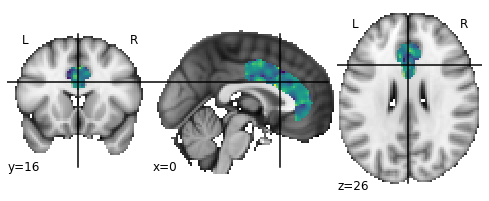

In [11]:
PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

### CorrectGoFollowingFailedStop

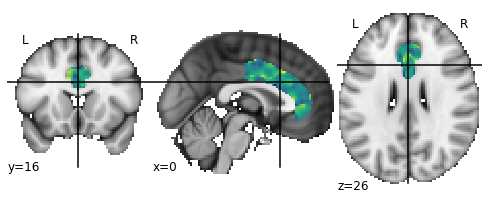

In [12]:
PostError_ns=results[3]['CorrectGoFollowingFailedStop']
display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

## Learn with neurosynth error keyword mask

In [13]:
neurosynth_error_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/error_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()

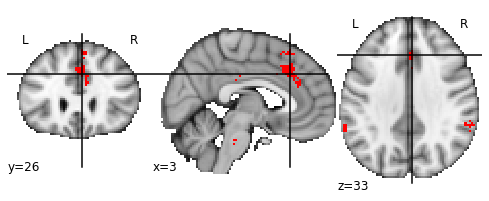

In [14]:
plotting.plot_img(
    neurosynth_error_mask,
    threshold='auto',
    cmap='autumn',
    
    bg_img=background_img)

This was not a very good score. We should try on the error signal as well rather than just ACC, and then repeat on the whole brain.

In [15]:
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_neurosynth_error_mask.pkl"

In [16]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=neurosynth_error_mask
    )

In [17]:
print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl


In [18]:
np.mean(results[0])

0.7283950617283951

### emotion regulation mask

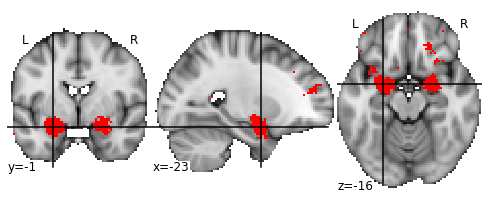

In [20]:
neurosynth_emo_reg_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()

plotting.plot_img(
    neurosynth_emo_reg_mask,
    threshold='auto',
    cmap='autumn',
    
    bg_img=background_img)

results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_neurosynth_emo_reg_mask.pkl"


In [21]:

if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=neurosynth_emo_reg_mask
    )
    


In [22]:
print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
0.691358024691358


### What next?

Try whole-brain?

In [7]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [8]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [9]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )

In [10]:
print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888


## more masks

In [7]:
neurosynth_dlpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/dlpfc_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_vmpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/vmpfc_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_resting_state_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/resting state_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()

neurosynth_negative_emotions_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/negative emotions_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_negative_affect_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/negative affect_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_self_referential_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/self referential_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()


vmpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz').threshold(binarize=True).to_nifti()
dlpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Middle Frontal Gyrus.nii.gz').threshold(binarize=True).to_nifti()
#harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz


mask_dict ={
    'dlpfc_mask':dlpfc_mask,
    'vmpfc_mask':vmpfc_mask,
    'neurosynth_resting_state_mask':neurosynth_resting_state_mask,
    'neurosynth_vmpfc_mask':neurosynth_vmpfc_mask,
    'neurosynth_dlpfc_mask':neurosynth_dlpfc_mask,
    'neurosynth_negative_emotions_mask':neurosynth_negative_emotions_mask,
    'neurosynth_negative_affect_mask':neurosynth_negative_affect_mask,
    'neurosynth_self_referential_mask':neurosynth_self_referential_mask
}

In [8]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


# dlpfc_mask

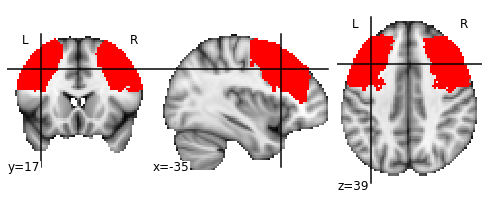

# vmpfc_mask

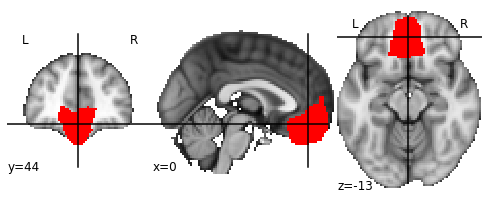

# neurosynth_resting_state_mask

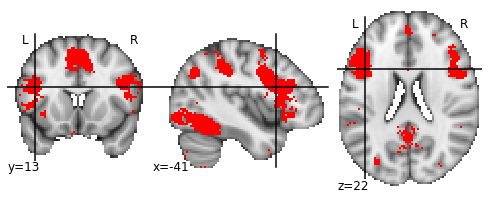

# neurosynth_vmpfc_mask

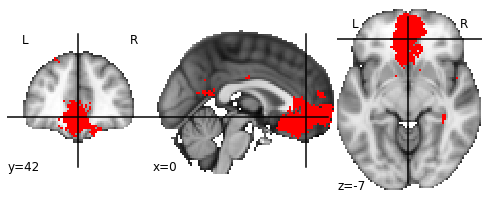

# neurosynth_dlpfc_mask

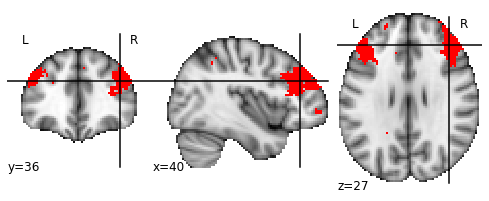

# neurosynth_negative_emotions_mask

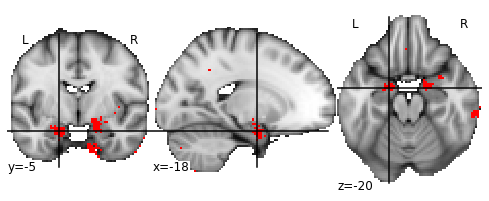

# neurosynth_negative_affect_mask

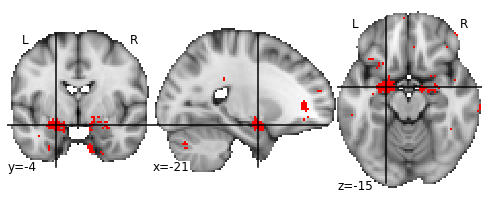

# neurosynth_self_referential_mask

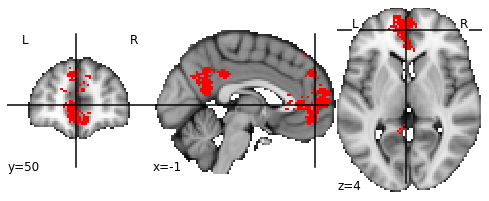

In [9]:
for mask_name in mask_dict.keys():
    display(Markdown("# " + mask_name))
    mask_bd = mask_dict[mask_name]
    
    plotting.plot_img(
        mask_bd,
        threshold='auto',
        cmap='autumn',

        bg_img=background_img)
    plotting.show()

# dlpfc_mask

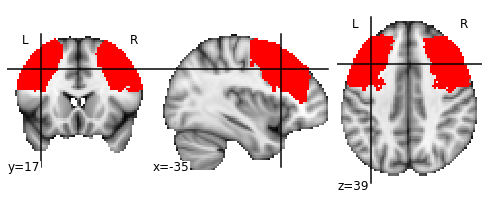

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_dlpfc_mask.pkl
0.7037037037037037


# vmpfc_mask

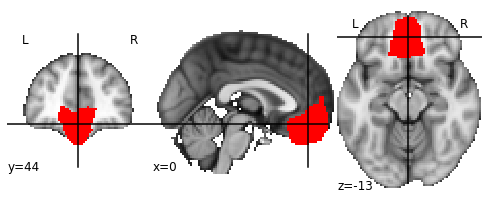

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_vmpfc_mask.pkl
0.5308641975308642


# neurosynth_resting_state_mask

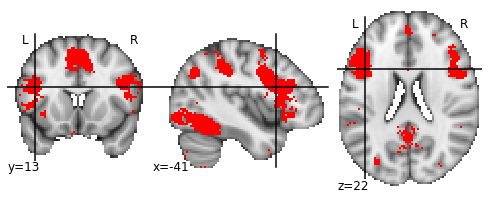

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_resting_state_mask.pkl
0.7777777777777778


# neurosynth_vmpfc_mask

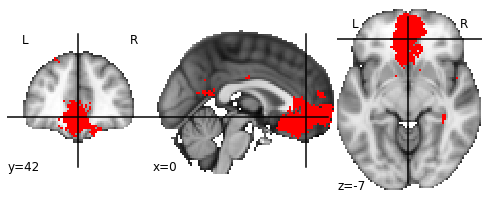

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_vmpfc_mask.pkl
0.6851851851851852


# neurosynth_dlpfc_mask

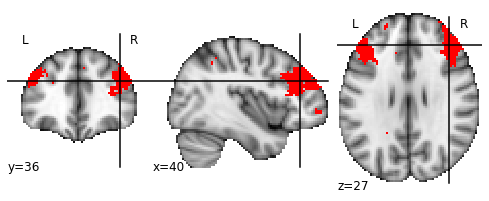

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_dlpfc_mask.pkl
0.6172839506172839


# neurosynth_negative_emotions_mask

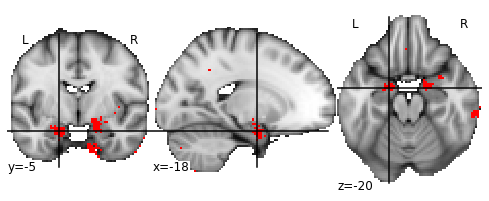

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_emotions_mask.pkl
0.6111111111111112


# neurosynth_negative_affect_mask

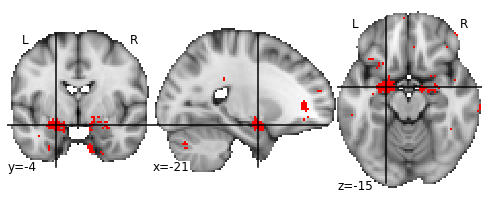

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_affect_mask.pkl
0.6481481481481481


# neurosynth_self_referential_mask

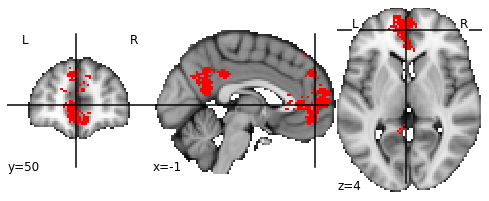

checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 162
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
subjs_to_use: 16
162
162


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


starting LeaveOneOut
finished preprocessing
Groups are the same.
fold 1 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. predicting. test score was:. 1.0
fold 2 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 3 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 4 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 5 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 6 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 7 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 8 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 9 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 10 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 11 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 12 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 13 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 14 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 15 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 16 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 17 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 18 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 19 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 20 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 21 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 22 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 23 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 24 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 25 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV030']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 26 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 27 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 28 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 29 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV089']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 30 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 31 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 32 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 33 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 34 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 35 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 36 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 37 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 38 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 39 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 40 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 41 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 42 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 43 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 44 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 45 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV016']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 46 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 47 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 48 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 49 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 50 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV034']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 51 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 52 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 53 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 54 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 55 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 56 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 57 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 58 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 59 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV218']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 60 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 61 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 62 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 63 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 64 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 65 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 66 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 67 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV177']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 68 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 69 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 70 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 71 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 72 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 73 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 74 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 75 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 76 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 77 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 78 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 79 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
fold 80 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.0
fold 81 of 81
In order to test on a training group of 80 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 1.0
1.0
1.0
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_self_referential_mask.pkl
0.6666666666666666


In [10]:
for mask_name in mask_dict.keys():
    display(Markdown("# " + mask_name))
    mask_bd = mask_dict[mask_name]
    
    plotting.plot_img(
        mask_bd,
        threshold='auto',
        cmap='autumn',

        bg_img=background_img)
    plotting.show()
    
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + mask_name + ".pkl"
    
    
    if path.exists(results_filepath) is False:
        apply_loocv_and_save(
            results_filepath = results_filepath,
            brain_data_filepath = brain_data_filepath,
            train_test_markers_filepath = train_test_markers_filepath,
    #        subjs_to_use = 60,
            decoderConstructor = decoderConstructor,
            response_transform_func=condition_resp_trans_func,
            mask=mask_bd
        )
        
    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))



    